##### Evaluation Notebook for the results on both pre-trained model inference performance and noisy label-training

- Since the models were trained on Google-Colab with conda generated environment, the following dependencies need to be installed prior to running the inference results and metrics

In [5]:
# If running on Google Colab, you need to install conda environment so setting up required dependencies
!pip install -q condacolab
import condacolab
condacolab.install()
# runtime would restart after the execution of the above block

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:07
🔁 Restarting kernel...


In [1]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/in-context-learning-trees
%load_ext autoreload
%autoreload 2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/in-context-learning-trees


In [6]:
## Creating custom environment - uncomment and run for the first time if running in colab
#!conda env create -f environment.yml


##### Run the following cell to train model from a custom config file.

The following configurations were tested for this project:
- gaussian noise: 0
- gaussian noise: 0.05
- gaussian noise: 1
- gaussian noise: 3

In [21]:
# # run the below in the terminal (Google Colab Pro required)
# %%shell
# cd src
# eval "$(conda shell.bash hook)" # copy conda command to shell
# conda activate in-context-learning
# python --version
# python /content/drive/MyDrive/in-context-learning-trees/src/train.py --config conf/noisy_decision_std_0.05.yaml

##### Evaluating Model Performance on pre-trained weights from Garg. Paper:

Given that this model was trained on 100 prompting examples with dimension d = 20, we evaluated the in-context learning ability of a GPT2 Transformer on learning decision tree algorithm with the following 3 prompting strategies:
- standard prompting (in-context examples have the same distribution as the x_query)
- random quadrant prompting (in-context examples were drawn from random quadrants and x_query was drawn from a different quadrant) to assess model robustness
- overlapping prompt train_test (overlapping distribution points in both prompting examples and x_query)


***The following cells of the notebook are recommended to be run in a local environment as they require plotting computed metrics for which a gpu is not required and running in a local machine would avoid the environment dependency issues as encountered in colab***

In [3]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
1,pretrained,decision_tree,Transformer,depth=4,-1,-1,20,12,8,decision_tree_pretrained
5,pretrained,linear_regression,Transformer,,-1,-1,20,12,8,linear_regression_pretrained
4,ad3c9587-70c4-4d5d-aa8d-7a0cfe75b029,noisy_decision_tree_std_0,Transformer,depth=4_noise_std=0,-1,-1,8,12,8,noisy_decision_tree_std_0
3,254bb2ec-87bd-493a-a144-26080b5105db,noisy_decision_tree_std_1,Transformer,depth=4_noise_std=1,-1,-1,8,12,8,noisy_decision_tree_std_1_depth_4
6,ea1d9c14-2099-4bf1-88fe-d08017fbc2e4,noisy_decision_tree_std_3,Transformer,depth=4_noise_std=3,-1,-1,8,12,8,noisy_decision_tree_std_3_depth_4
0,pretrained,relu_2nn_regression,Transformer,hidden_layer_size=100,-1,-1,20,12,8,relu_2nn_regression_pretrained
2,pretrained,sparse_linear_regression,Transformer,sparsity=3,-1,-1,20,12,8,sparse_regression_pretrained


In [6]:
#task = "linear_regression"
#task = "sparse_linear_regression"
task = "decision_tree"
#task = "relu_2nn_regression"
# task = "noisy_decision_tree_std_0"
# task = "noisy_decision_tree_std_0.05"
# task = "noisy_decision_tree_std_1"
# task = "noisy_decision_tree_std_3"

run_id = "pretrained"  # if you train more models, replace with the run_id from the table above

run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = False

if recompute_metrics:
    get_run_metrics(run_path)  # these are normally precomputed at the end of training

##### Checking model robustness trained on noise-free labels on various prompting strategies:

../models/decision_tree/pretrained
decision_tree_pretrained pretrained
recompute: False


  0%|          | 0/3 [00:00<?, ?it/s]

standard


0it [00:00, ?it/s]


random_quadrants


0it [00:00, ?it/s]


overlapping_train_test


0it [00:00, ?it/s]
100%|██████████| 3/3 [00:00<00:00, 39.98it/s]


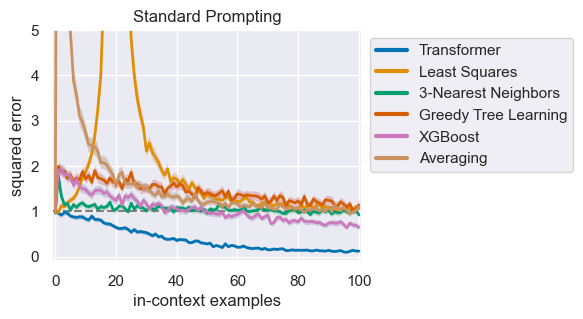

scale: 5.0


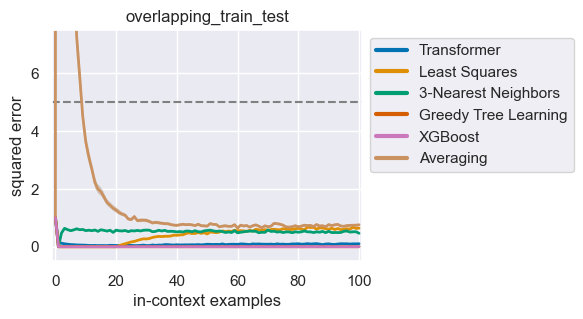

scale: 5.0


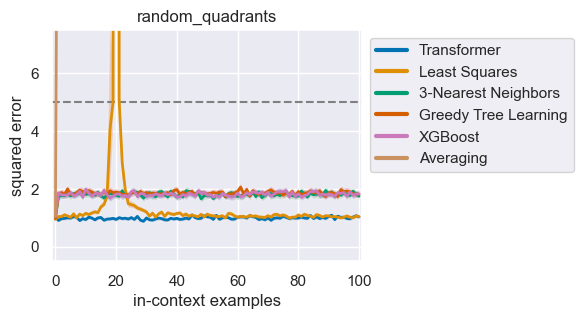

In [13]:
import os
import matplotlib.pyplot as plt

def process_task_run(task, run_id, run_dir, df, relevant_model_names):
    run_path = os.path.join(run_dir, task, run_id)
    print(run_path)
    recompute_metrics = False
    
    if recompute_metrics:
        get_run_metrics(run_path)  # Assume this function is defined elsewhere to recompute metrics

    def valid_row(r):
        return r.task == task and r.run_id == run_id

    # Collect results based on valid_row filter
    metrics = collect_results(run_dir, df, valid_row=valid_row)
    _, conf = get_model_from_run(run_path, only_conf=True)
    n_dims = conf.model.n_dims

    # Plot standard metrics
    models = relevant_model_names[task]
    fig, ax = basic_plot(metrics["standard"], models=models)
    ax.set_title("Standard Prompting")
    plt.show()

    # Plot any OOD metrics
    for name, metric in metrics.items():
        if name == "standard":
            continue

        scale = float(name.split("=")[-1])**2 if "scale" in name else 5.0
        print(f"scale: {scale}")
        trivial = 1.0 if "noisy" not in name else (1 + 1 / n_dims)

        fig, ax = basic_plot(metric, models=models, trivial=trivial * scale)
        ax.set_title(name)

        if "ortho" in name:
            ax.set_xlim(-1, n_dims - 1)
        ax.set_ylim(-.1 * scale, 1.5 * scale)

        plt.show()

process_task_run("decision_tree", "pretrained", run_dir, df, relevant_model_names) 


##### Plotting Training Loss on self-trained models:

<Figure size 1000x600 with 0 Axes>

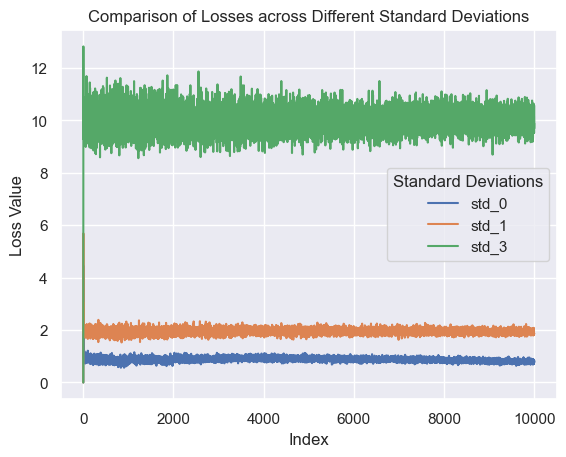

In [16]:
losses_std_0 = pd.read_csv("../models/noisy_decision_tree_std_0/ad3c9587-70c4-4d5d-aa8d-7a0cfe75b029/losses_model_10000.csv",names=['std_0'])
losses_std_1 = pd.read_csv("../models/noisy_decision_tree_std_1/254bb2ec-87bd-493a-a144-26080b5105db/losses_model_10000.csv",names=["std_1"])
losses_std_3 = pd.read_csv("../models/noisy_decision_tree_std_3/ea1d9c14-2099-4bf1-88fe-d08017fbc2e4/losses_model_10000.csv",names=["std_3"])


losses = pd.concat([losses_std_0,losses_std_1,losses_std_3],axis=1)

plt.figure(figsize=(10, 6))  # Set the figure size for better readability
losses.plot(kind='line')  # Plotting the data

# Adding title and labels
plt.title('Comparison of Losses across Different Standard Deviations')
plt.xlabel('Index')
plt.ylabel('Loss Value')

# Adding legend
plt.legend(title='Standard Deviations')

# Show the plot
plt.show()



##### Model performance on noisy training: std 0


../models/noisy_decision_tree_std_0/ad3c9587-70c4-4d5d-aa8d-7a0cfe75b029
noisy_decision_tree_std_0 ad3c9587-70c4-4d5d-aa8d-7a0cfe75b029
recompute: False


  0%|          | 0/3 [00:00<?, ?it/s]

standard


0it [00:00, ?it/s]


random_quadrants


0it [00:00, ?it/s]


overlapping_train_test


0it [00:00, ?it/s]
100%|██████████| 3/3 [00:00<00:00, 343.72it/s]


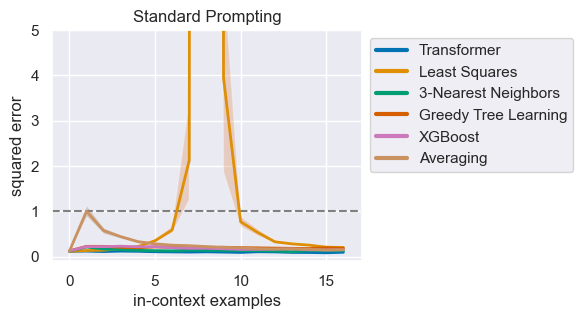

scale: 5.0


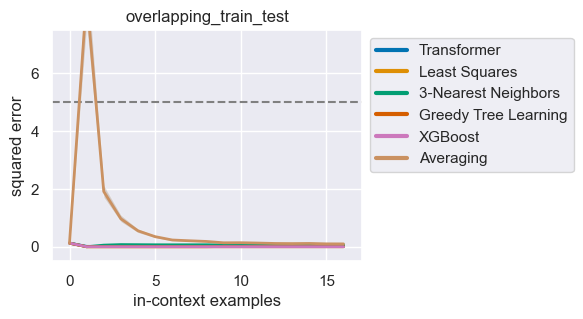

scale: 5.0


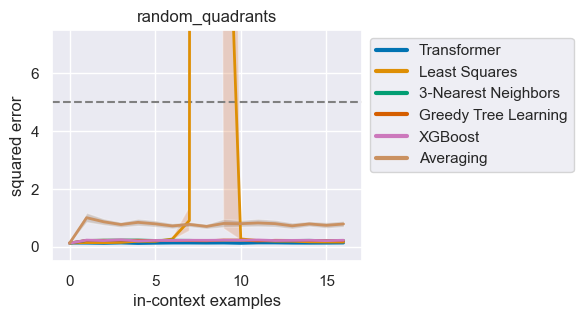

In [19]:
task = "noisy_decision_tree_std_0"
run_id = "ad3c9587-70c4-4d5d-aa8d-7a0cfe75b029"

process_task_run(task, run_id, run_dir, df, relevant_model_names)

##### Model performance on noisy training: std = 1

../models/noisy_decision_tree_std_1/254bb2ec-87bd-493a-a144-26080b5105db
noisy_decision_tree_std_1_depth_4 254bb2ec-87bd-493a-a144-26080b5105db
recompute: False


  0%|          | 0/3 [00:00<?, ?it/s]

standard


0it [00:00, ?it/s]


random_quadrants


0it [00:00, ?it/s]


overlapping_train_test


0it [00:00, ?it/s]
100%|██████████| 3/3 [00:00<00:00, 403.54it/s]


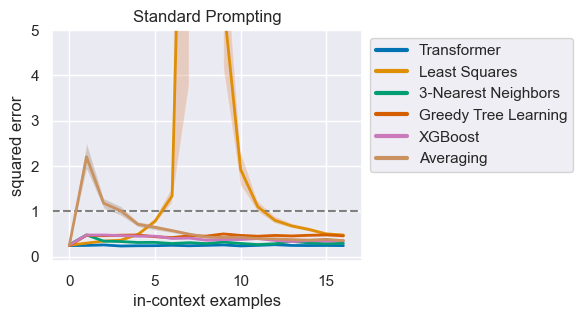

scale: 5.0


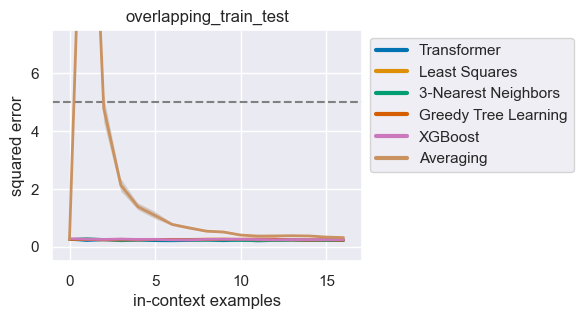

scale: 5.0


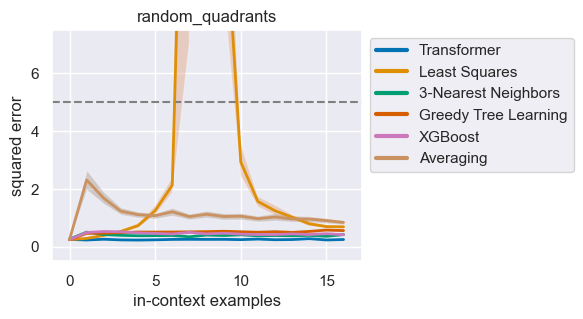

In [18]:
task = "noisy_decision_tree_std_1"
run_id = "254bb2ec-87bd-493a-a144-26080b5105db"


process_task_run(task, run_id, run_dir, df, relevant_model_names)

##### Model performance on noisy training std: 3

../models/noisy_decision_tree_std_3/ea1d9c14-2099-4bf1-88fe-d08017fbc2e4
noisy_decision_tree_std_3_depth_4 ea1d9c14-2099-4bf1-88fe-d08017fbc2e4
recompute: False


  0%|          | 0/3 [00:00<?, ?it/s]

standard


0it [00:00, ?it/s]


random_quadrants


0it [00:00, ?it/s]


overlapping_train_test


0it [00:00, ?it/s]
100%|██████████| 3/3 [00:00<00:00, 385.20it/s]


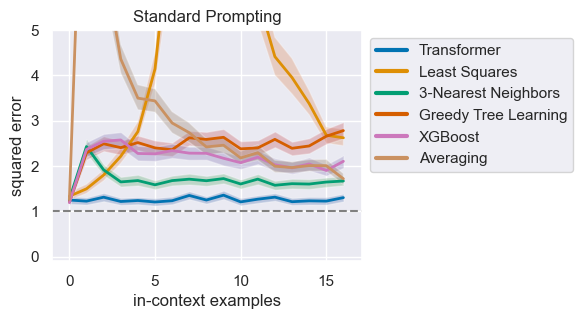

scale: 5.0


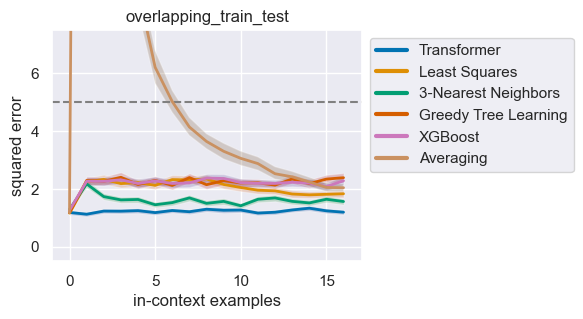

scale: 5.0


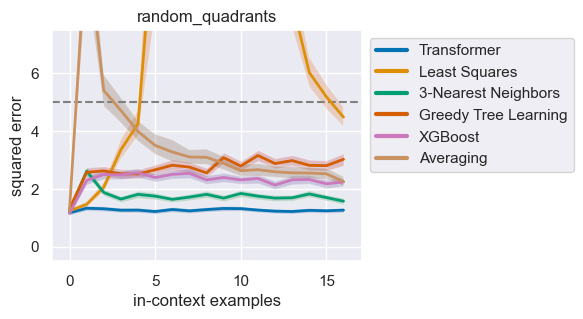

In [15]:
task = "noisy_decision_tree_std_3"
run_id = "ea1d9c14-2099-4bf1-88fe-d08017fbc2e4"
process_task_run(task, run_id, run_dir, df, relevant_model_names)